# Multi-class Classification with VGG16 on CIFAR-10

In [1]:
!pip install tensorflow scikit-learn --quiet

### Import Required Libraries
- TensorFlow/Keras for building and training the CNN
- ImageDataGenerator for loading and augmenting image data
- Scikit-learn for handling class imbalance and evaluation metrics
- Matplotlib/Seaborn for visualizing the confusion matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

### Preprocessing
Preprocessing function to resize and normalize images, and cast labels to float32

In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Load Pretrained VGG16 Base Model
- Use `VGG16` with `include_top=False` to exclude final dense layers.
- Unfreeze last few convolutional layers of VGG16.

In [17]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

### Add Custom Classification Head
- Add `GlobalAveragePooling2D` to reduce spatial dimensions.
- Add dense layer with ReLU and Dropout.
- Add softmax output layer for 10-class prediction.

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

<img src="https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/network.png">

<img src="https://www.researchgate.net/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png">

In [29]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,676,896 (113.21 MB)

 Trainable params: 7,347,210 (28.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,694,422 (56.05 MB)

### Compile the Model
- Use `Adam` optimizer with low learning rate.
- Set loss to `categorical_crossentropy`.
- Track accuracy as the evaluation metric.

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### Train the Model (Feature Extraction)
- Train only the classification head with base VGG16 frozen.
- Use `validation_split` to monitor validation performance.

In [20]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 336s 213ms/step - accuracy: 0.2173 - loss: 2.1564 - val_accuracy: 0.4490 - val_loss: 1.7189


### Unfreeze Layers for Fine-Tuning
- Unfreeze last few convolutional layers of VGG16.
- Recompile with an even lower learning rate to avoid destroying pretrained weights.


In [21]:
### Unfreeze Some Layers for Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Fine-tune only last 4 conv layers
    layer.trainable = False

In [22]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

### Continue Training (Fine-Tuning)
- Resume training with a few unfrozen layers to boost performance.

In [23]:
fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 383s 242ms/step - accuracy: 0.5296 - loss: 1.3443 - val_accuracy: 0.6968 - val_loss: 0.8779


### Evaluate the Model on Test Set
- Report final accuracy on test data.

In [24]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.6966 - loss: 0.8754
Test Accuracy: 0.6968


In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

### Generate Classification Report
- Predict test labels.
- Use `classification_report()` to show precision, recall, and F1-score.

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1000
           1       0.80      0.89      0.84      1000
           2       0.60      0.66      0.63      1000
           3       0.50      0.57      0.53      1000
           4       0.68      0.50      0.58      1000
           5       0.63      0.58      0.60      1000
           6       0.80      0.63      0.71      1000
           7       0.67      0.80      0.73      1000
           8       0.88      0.71      0.79      1000
           9       0.88      0.74      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



### Plot Confusion Matrix
- Compute and visualize confusion matrix to analyze misclassifications.

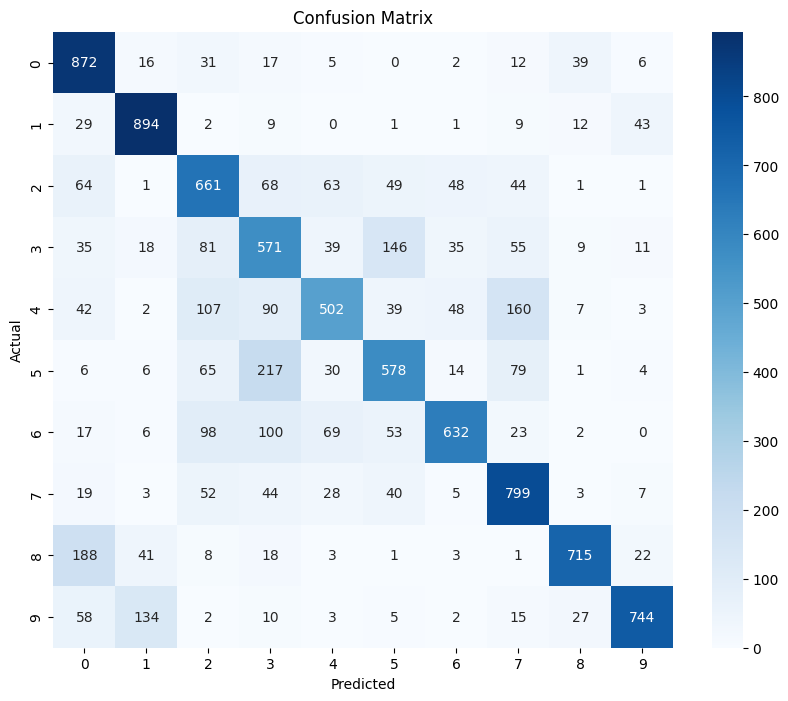

In [27]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()